In [1]:
from datagen import generator
from model import build_seg_model

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')

In [3]:
import os, glob
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import IPython

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [6]:
## config

BASE_PATH = glob.glob('/home/centos/jupyter/pathology/data/img/patch_overlap_global_512//*/*') # all patients
TRAIN_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[:int(0.60*len(BASE_PATH))]
VALID_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[int(0.60*len(BASE_PATH)):int(0.80*len(BASE_PATH))]
TEST_PATIENT_PATH = shuffle(BASE_PATH,random_state=311)[int(0.80*len(BASE_PATH)):]
TRAIN_IMG_PATH = []; TRAIN_TARGET_PATH = []
for x in TRAIN_PATIENT_PATH:
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    TRAIN_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:50],random_state=311))
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:3])
VALID_IMG_PATH = []; VALID_TARGET_PATH = []
for x in VALID_PATIENT_PATH:
    VALID_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    VALID_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:50],random_state=311))
    VALID_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:3])
    
TEST_IMG_PATH = []; TEST_TARGET_PATH = []
for x in TEST_PATIENT_PATH:
    TEST_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[2].png'))
    TEST_TARGET_PATH.extend(shuffle(glob.glob(x+'/mask/*_p[3].png')[:50],random_state=311))
    TEST_TARGET_PATH.extend(glob.glob(x+'/mask/*_p[4].png')[:3])
    
TRAIN_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TRAIN_TARGET_PATH],
    random_state=311
)
VALID_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in VALID_TARGET_PATH]
    ,random_state=311
)
TEST_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TEST_TARGET_PATH]
    ,random_state=311
)

BATCH_SIZE = 32
INPUT_SHAPE = (512,512)
NUM_CLASSES = 2
EPOCHS = 100

In [7]:
print(len(TRAIN_PATIENT_PATH))
print(len(VALID_PATIENT_PATH))
print(len(TEST_PATIENT_PATH))

89
30
30


In [8]:
print(len([x for x in TRAIN_ZIP if '_p3' in x[1]]))
print(len([x for x in TRAIN_ZIP if '_p4' in x[1]]))
print(len([x for x in VALID_ZIP if '_p3' in x[1]]))
print(len([x for x in VALID_ZIP if '_p4' in x[1]]))
print(len([x for x in TEST_ZIP if '_p3' in x[1]]))
print(len([x for x in TEST_ZIP if '_p4' in x[1]]))

3691
261
1186
87
1182
87


In [9]:
print(len(TRAIN_ZIP),len(VALID_ZIP),len(TEST_ZIP))

6906 2029 1975


In [10]:
train_gen = generator(BATCH_SIZE,INPUT_SHAPE,TRAIN_ZIP,is_train=True)
valid_gen = generator(BATCH_SIZE,INPUT_SHAPE,VALID_ZIP,is_train=False)
test_gen = generator(BATCH_SIZE,INPUT_SHAPE,TEST_ZIP,is_train=False)

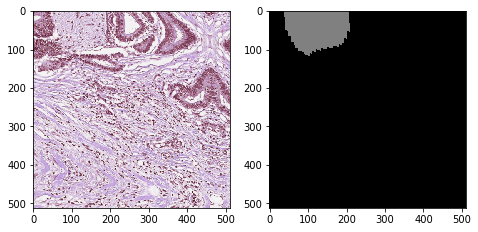

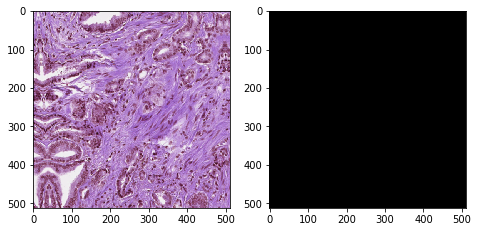

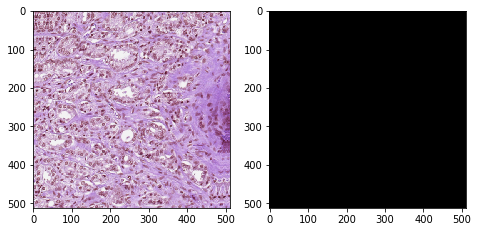

In [11]:
for idx in range(0,3):
    
    batch_x,batch_y = train_gen.__getitem__(5)
    plt.figure(figsize = (12,6));
    d = np.unique(batch_x,return_counts=True)
    plt.subplot(1,3,1);plt.imshow((255*batch_x[idx]).astype(np.int32))
    plt.subplot(1,3,2);plt.imshow(np.squeeze(batch_y[idx],axis=-1),vmin=0,vmax=2)
    #plt.subplot(1,3,3);plt.bar(d[0],d[1])

---

## KERA-TUNER

In [12]:
from kerastuner import Hyperband, HyperParameter, HyperParameters, HyperModel

In [21]:
def build_model(hp):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    total_loss = dice_loss + focal_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    BACKBONE = hp.Choice('backbone',['inceptionresnetv2','inceptionv3'])
    model = sm.Unet(BACKBONE,input_shape=(512,512,3),classes=1,activation='sigmoid',encoder_weights='imagenet')
    '''
    if hp.Choice('optimizer',['adam','sgd'])=='adam':
        model.compile(Adam(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    else:
        model.compile(SGD(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    '''
    model.compile(optimizer = Adam(hp.Float('learning_rate',1e-4,1e-2)),loss=total_loss,metrics=metrics)
    return model

In [22]:
## CALLBACK
model_path='./data/model/seg_0718.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 4)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=2,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
callbacks_list = [mc,es,lr,ClearTrainingOutput()]

In [23]:
tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='nerve_segmentation'
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [24]:
tuner.search(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10,
    callbacks = callbacks_list
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 215 steps, validate for 63 steps
Epoch 1/10


124/215 [================>.............] - ETA: 2:48:11 - loss: 0.9606 - iou_score: 0.0655 - f1-score: 0.123 - ETA: 1:46:48 - loss: 0.9234 - iou_score: 0.0670 - f1-score: 0.125 - ETA: 1:23:39 - loss: 0.9125 - iou_score: 0.0639 - f1-score: 0.120 - ETA: 1:15:35 - loss: 0.9093 - iou_score: 0.0561 - f1-score: 0.105 - ETA: 1:08:58 - loss: 0.9087 - iou_score: 0.0521 - f1-score: 0.098 - ETA: 1:06:19 - loss: 0.9040 - iou_score: 0.0476 - f1-score: 0.090 - ETA: 1:01:28 - loss: 0.8927 - iou_score: 0.0433 - f1-score: 0.082 - ETA: 59:13 - loss: 0.8837 - iou_score: 0.0498 - f1-score: 0.0939  - ETA: 56:08 - loss: 0.8721 - iou_score: 0.0638 - f1-score: 0.116 - ETA: 54:45 - loss: 0.8701 - iou_score: 0.0684 - f1-score: 0.124 - ETA: 53:07 - loss: 0.8713 - iou_score: 0.0707 - f1-score: 0.128 - ETA: 51:12 - loss: 0.8642 - iou_score: 0.0800 - f1-score: 0.143 - ETA: 50:04 - loss: 0.8679 - iou_score: 0.0784 - f1-score: 0.141 - ETA: 48:20 - loss: 0.8628 - iou_score: 0.0838 - f1-score: 0.150 - ETA: 47:32 - loss

214/215 [============================>.] - ETA: 19:03 - loss: 0.6233 - iou_score: 0.3213 - f1-score: 0.468 - ETA: 18:53 - loss: 0.6228 - iou_score: 0.3212 - f1-score: 0.468 - ETA: 18:41 - loss: 0.6210 - iou_score: 0.3229 - f1-score: 0.470 - ETA: 18:30 - loss: 0.6192 - iou_score: 0.3245 - f1-score: 0.471 - ETA: 18:21 - loss: 0.6180 - iou_score: 0.3258 - f1-score: 0.473 - ETA: 18:08 - loss: 0.6178 - iou_score: 0.3262 - f1-score: 0.473 - ETA: 17:55 - loss: 0.6164 - iou_score: 0.3274 - f1-score: 0.475 - ETA: 17:43 - loss: 0.6182 - iou_score: 0.3260 - f1-score: 0.473 - ETA: 17:32 - loss: 0.6165 - iou_score: 0.3276 - f1-score: 0.475 - ETA: 17:20 - loss: 0.6153 - iou_score: 0.3286 - f1-score: 0.476 - ETA: 17:07 - loss: 0.6144 - iou_score: 0.3299 - f1-score: 0.477 - ETA: 16:55 - loss: 0.6131 - iou_score: 0.3310 - f1-score: 0.479 - ETA: 16:41 - loss: 0.6121 - iou_score: 0.3321 - f1-score: 0.480 - ETA: 16:29 - loss: 0.6111 - iou_score: 0.3330 - f1-score: 0.481 - ETA: 16:19 - loss: 0.6107 - iou_s

124/215 [================>.............] - ETA: 1:00:00 - loss: 0.5456 - iou_score: 0.3255 - f1-score: 0.491 - ETA: 51:00 - loss: 0.4614 - iou_score: 0.4206 - f1-score: 0.5858  - ETA: 44:54 - loss: 0.4183 - iou_score: 0.4668 - f1-score: 0.629 - ETA: 45:32 - loss: 0.4502 - iou_score: 0.4373 - f1-score: 0.601 - ETA: 47:32 - loss: 0.4287 - iou_score: 0.4558 - f1-score: 0.619 - ETA: 45:27 - loss: 0.4297 - iou_score: 0.4571 - f1-score: 0.622 - ETA: 45:33 - loss: 0.4287 - iou_score: 0.4637 - f1-score: 0.628 - ETA: 44:25 - loss: 0.4158 - iou_score: 0.4812 - f1-score: 0.644 - ETA: 45:29 - loss: 0.4260 - iou_score: 0.4749 - f1-score: 0.638 - ETA: 46:09 - loss: 0.4234 - iou_score: 0.4795 - f1-score: 0.643 - ETA: 44:23 - loss: 0.4193 - iou_score: 0.4844 - f1-score: 0.648 - ETA: 43:57 - loss: 0.4207 - iou_score: 0.4858 - f1-score: 0.650 - ETA: 43:04 - loss: 0.4305 - iou_score: 0.4814 - f1-score: 0.646 - ETA: 42:55 - loss: 0.4202 - iou_score: 0.4947 - f1-score: 0.657 - ETA: 43:09 - loss: 0.4243 - i

214/215 [============================>.] - ETA: 17:35 - loss: 0.4132 - iou_score: 0.5107 - f1-score: 0.669 - ETA: 17:23 - loss: 0.4126 - iou_score: 0.5112 - f1-score: 0.669 - ETA: 17:12 - loss: 0.4122 - iou_score: 0.5114 - f1-score: 0.670 - ETA: 17:02 - loss: 0.4122 - iou_score: 0.5115 - f1-score: 0.670 - ETA: 16:50 - loss: 0.4115 - iou_score: 0.5123 - f1-score: 0.671 - ETA: 16:38 - loss: 0.4105 - iou_score: 0.5133 - f1-score: 0.671 - ETA: 16:25 - loss: 0.4100 - iou_score: 0.5139 - f1-score: 0.672 - ETA: 16:13 - loss: 0.4103 - iou_score: 0.5138 - f1-score: 0.672 - ETA: 16:01 - loss: 0.4102 - iou_score: 0.5141 - f1-score: 0.672 - ETA: 15:51 - loss: 0.4091 - iou_score: 0.5153 - f1-score: 0.673 - ETA: 15:38 - loss: 0.4077 - iou_score: 0.5169 - f1-score: 0.674 - ETA: 15:29 - loss: 0.4076 - iou_score: 0.5169 - f1-score: 0.675 - ETA: 15:17 - loss: 0.4085 - iou_score: 0.5158 - f1-score: 0.674 - ETA: 15:05 - loss: 0.4075 - iou_score: 0.5166 - f1-score: 0.674 - ETA: 14:53 - loss: 0.4077 - iou_s

124/215 [================>.............] - ETA: 40:05 - loss: 0.4218 - iou_score: 0.4985 - f1-score: 0.665 - ETA: 39:25 - loss: 0.3964 - iou_score: 0.5201 - f1-score: 0.684 - ETA: 40:30 - loss: 0.3809 - iou_score: 0.5281 - f1-score: 0.691 - ETA: 41:33 - loss: 0.3679 - iou_score: 0.5389 - f1-score: 0.700 - ETA: 41:46 - loss: 0.3684 - iou_score: 0.5383 - f1-score: 0.699 - ETA: 43:03 - loss: 0.3829 - iou_score: 0.5261 - f1-score: 0.688 - ETA: 42:46 - loss: 0.3795 - iou_score: 0.5278 - f1-score: 0.690 - ETA: 41:50 - loss: 0.3672 - iou_score: 0.5417 - f1-score: 0.701 - ETA: 40:42 - loss: 0.3554 - iou_score: 0.5556 - f1-score: 0.712 - ETA: 40:29 - loss: 0.3683 - iou_score: 0.5423 - f1-score: 0.700 - ETA: 39:24 - loss: 0.3729 - iou_score: 0.5411 - f1-score: 0.699 - ETA: 39:13 - loss: 0.3633 - iou_score: 0.5512 - f1-score: 0.707 - ETA: 39:04 - loss: 0.3647 - iou_score: 0.5499 - f1-score: 0.707 - ETA: 39:15 - loss: 0.3724 - iou_score: 0.5420 - f1-score: 0.700 - ETA: 38:44 - loss: 0.3685 - iou_s

214/215 [============================>.] - ETA: 16:54 - loss: 0.3755 - iou_score: 0.5502 - f1-score: 0.703 - ETA: 16:41 - loss: 0.3747 - iou_score: 0.5511 - f1-score: 0.704 - ETA: 16:28 - loss: 0.3749 - iou_score: 0.5510 - f1-score: 0.704 - ETA: 16:17 - loss: 0.3749 - iou_score: 0.5506 - f1-score: 0.704 - ETA: 16:03 - loss: 0.3751 - iou_score: 0.5503 - f1-score: 0.704 - ETA: 15:51 - loss: 0.3746 - iou_score: 0.5508 - f1-score: 0.704 - ETA: 15:39 - loss: 0.3750 - iou_score: 0.5504 - f1-score: 0.704 - ETA: 15:26 - loss: 0.3742 - iou_score: 0.5509 - f1-score: 0.704 - ETA: 15:14 - loss: 0.3735 - iou_score: 0.5517 - f1-score: 0.705 - ETA: 15:04 - loss: 0.3731 - iou_score: 0.5519 - f1-score: 0.705 - ETA: 14:53 - loss: 0.3740 - iou_score: 0.5515 - f1-score: 0.705 - ETA: 14:40 - loss: 0.3733 - iou_score: 0.5522 - f1-score: 0.705 - ETA: 14:31 - loss: 0.3733 - iou_score: 0.5525 - f1-score: 0.706 - ETA: 14:21 - loss: 0.3727 - iou_score: 0.5527 - f1-score: 0.706 - ETA: 14:09 - loss: 0.3731 - iou_s

124/215 [================>.............] - ETA: 40:52 - loss: 0.3358 - iou_score: 0.5755 - f1-score: 0.730 - ETA: 38:39 - loss: 0.2658 - iou_score: 0.6529 - f1-score: 0.787 - ETA: 37:51 - loss: 0.2631 - iou_score: 0.6625 - f1-score: 0.795 - ETA: 36:47 - loss: 0.2826 - iou_score: 0.6432 - f1-score: 0.781 - ETA: 38:17 - loss: 0.3027 - iou_score: 0.6200 - f1-score: 0.762 - ETA: 36:58 - loss: 0.3032 - iou_score: 0.6173 - f1-score: 0.761 - ETA: 37:37 - loss: 0.3161 - iou_score: 0.5989 - f1-score: 0.746 - ETA: 38:52 - loss: 0.3254 - iou_score: 0.5929 - f1-score: 0.741 - ETA: 38:49 - loss: 0.3459 - iou_score: 0.5787 - f1-score: 0.729 - ETA: 38:20 - loss: 0.3526 - iou_score: 0.5699 - f1-score: 0.722 - ETA: 39:04 - loss: 0.3444 - iou_score: 0.5777 - f1-score: 0.729 - ETA: 38:21 - loss: 0.3361 - iou_score: 0.5863 - f1-score: 0.735 - ETA: 38:14 - loss: 0.3279 - iou_score: 0.5942 - f1-score: 0.741 - ETA: 37:52 - loss: 0.3327 - iou_score: 0.5898 - f1-score: 0.738 - ETA: 37:35 - loss: 0.3328 - iou_s

214/215 [============================>.] - ETA: 16:42 - loss: 0.3537 - iou_score: 0.5716 - f1-score: 0.721 - ETA: 16:30 - loss: 0.3525 - iou_score: 0.5730 - f1-score: 0.722 - ETA: 16:19 - loss: 0.3520 - iou_score: 0.5735 - f1-score: 0.723 - ETA: 16:08 - loss: 0.3527 - iou_score: 0.5725 - f1-score: 0.722 - ETA: 15:55 - loss: 0.3518 - iou_score: 0.5735 - f1-score: 0.723 - ETA: 15:45 - loss: 0.3521 - iou_score: 0.5728 - f1-score: 0.722 - ETA: 15:33 - loss: 0.3503 - iou_score: 0.5749 - f1-score: 0.724 - ETA: 15:21 - loss: 0.3505 - iou_score: 0.5748 - f1-score: 0.724 - ETA: 15:10 - loss: 0.3511 - iou_score: 0.5737 - f1-score: 0.723 - ETA: 14:59 - loss: 0.3505 - iou_score: 0.5743 - f1-score: 0.723 - ETA: 14:48 - loss: 0.3505 - iou_score: 0.5743 - f1-score: 0.723 - ETA: 14:35 - loss: 0.3505 - iou_score: 0.5740 - f1-score: 0.723 - ETA: 14:24 - loss: 0.3514 - iou_score: 0.5732 - f1-score: 0.722 - ETA: 14:13 - loss: 0.3505 - iou_score: 0.5744 - f1-score: 0.723 - ETA: 14:02 - loss: 0.3504 - iou_s

124/215 [================>.............] - ETA: 35:06 - loss: 0.7367 - iou_score: 0.2105 - f1-score: 0.347 - ETA: 35:52 - loss: 0.5018 - iou_score: 0.4372 - f1-score: 0.572 - ETA: 38:14 - loss: 0.4542 - iou_score: 0.4694 - f1-score: 0.614 - ETA: 38:41 - loss: 0.4525 - iou_score: 0.4567 - f1-score: 0.608 - ETA: 37:06 - loss: 0.4075 - iou_score: 0.5022 - f1-score: 0.648 - ETA: 36:19 - loss: 0.3830 - iou_score: 0.5286 - f1-score: 0.673 - ETA: 36:06 - loss: 0.3705 - iou_score: 0.5424 - f1-score: 0.687 - ETA: 35:54 - loss: 0.3641 - iou_score: 0.5516 - f1-score: 0.696 - ETA: 35:57 - loss: 0.3689 - iou_score: 0.5560 - f1-score: 0.701 - ETA: 36:23 - loss: 0.3746 - iou_score: 0.5556 - f1-score: 0.702 - ETA: 35:16 - loss: 0.3684 - iou_score: 0.5629 - f1-score: 0.709 - ETA: 34:43 - loss: 0.3963 - iou_score: 0.5389 - f1-score: 0.686 - ETA: 35:12 - loss: 0.3881 - iou_score: 0.5456 - f1-score: 0.692 - ETA: 35:01 - loss: 0.3853 - iou_score: 0.5438 - f1-score: 0.692 - ETA: 36:02 - loss: 0.3800 - iou_s

167/215 [======================>.......] - ETA: 16:51 - loss: 0.3478 - iou_score: 0.5758 - f1-score: 0.725 - ETA: 16:42 - loss: 0.3484 - iou_score: 0.5751 - f1-score: 0.724 - ETA: 16:32 - loss: 0.3486 - iou_score: 0.5748 - f1-score: 0.724 - ETA: 16:21 - loss: 0.3481 - iou_score: 0.5753 - f1-score: 0.724 - ETA: 16:10 - loss: 0.3491 - iou_score: 0.5743 - f1-score: 0.723 - ETA: 16:00 - loss: 0.3485 - iou_score: 0.5750 - f1-score: 0.724 - ETA: 15:49 - loss: 0.3481 - iou_score: 0.5752 - f1-score: 0.724 - ETA: 15:39 - loss: 0.3473 - iou_score: 0.5761 - f1-score: 0.725 - ETA: 15:28 - loss: 0.3468 - iou_score: 0.5765 - f1-score: 0.725 - ETA: 15:19 - loss: 0.3466 - iou_score: 0.5766 - f1-score: 0.725 - ETA: 15:08 - loss: 0.3465 - iou_score: 0.5768 - f1-score: 0.726 - ETA: 14:56 - loss: 0.3483 - iou_score: 0.5752 - f1-score: 0.724 - ETA: 14:46 - loss: 0.3475 - iou_score: 0.5759 - f1-score: 0.725 - ETA: 14:35 - loss: 0.3464 - iou_score: 0.5770 - f1-score: 0.726 - ETA: 14:22 - loss: 0.3463 - iou_s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
tuner.results_summary()

---

In [10]:
CLASS = 'TUMOR'
MODE = 'Camelyon16_Augmentv02_DiceFocalLoss_alpha_025_gamma_6'
BACKBONE = 'inceptionresnetv2'
MODEL_PATH = './data/model/seg_0714.hdf5'

IMAGE_SIZE = 512
CHANNEL = 3
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 200

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1
activation = 'sigmoid' 

#create model
model = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=n_classes, activation=activation,encoder_weights=None)


In [11]:
# define optomizer
optim = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()

# default focal_loss (alpha=0.25, gamma=2.0)
focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
total_loss = dice_loss + focal_loss


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#metrics = [my_metric]

mc = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 8)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr]
#mc = ModelCheckpoint(history_files); lr = ReduceLROnPlateau()
#callback_list = [mc,lr]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 62,061,553
Trainable params: 61,999,025
Non-trainable params: 62,528
__________________________________________________________________________________________________


In [ ]:
history = model.fit(train_gen, 
                     epochs = EPOCHS,
                     validation_data=valid_gen,
                     callbacks=callbacks_list,
                     max
                    _queue_size=15,
                     use_multiprocessing=True,
                     verbose=1
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 348 steps, validate for 100 steps
Epoch 1/200
347/348 [============================>.] - ETA: 7s - loss: 0.5865 - iou_score: 0.3645 - f1-score: 0.5129 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_loss improved from inf to 2.56783, saving model to ./data/model/seg_0714.hdf5
348/348 [==============================] - 2664s 8s/step - loss: 0.5863 - iou_score: 0.3647 - f1-score: 0.5132 - val_loss: 2.5678 - val_iou_score: 0.0593 - val_f1-score: 0.1094
Epoch 2/200
347/348 [============================>.] - ETA: 7s - loss: 0.4486 - iou_score: 0.4865 - f1-score: 0.6454 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_loss improved from 2.56783 to 0.72856, saving m

347/348 [============================>.] - ETA: 6s - loss: 0.2174 - iou_score: 0.7191 - f1-score: 0.8333 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00024: val_loss improved from 0.33231 to 0.32961, saving model to ./data/model/seg_0714.hdf5
348/348 [==============================] - 2480s 7s/step - loss: 0.2171 - iou_score: 0.7194 - f1-score: 0.8335 - val_loss: 0.3296 - val_iou_score: 0.6098 - val_f1-score: 0.7481
Epoch 25/200
347/348 [============================>.] - ETA: 6s - loss: 0.2147 - iou_score: 0.7223 - f1-score: 0.8356 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00025: val_loss did not improve from 0.32961
348/348 [==============================] - 2504s 7s/step - loss: 0.2151 - iou_score: 0.7217 - f1-score: 0.8351 - v

347/348 [============================>.] - ETA: 7s - loss: 0.2000 - iou_score: 0.7381 - f1-score: 0.8466 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00036: val_loss did not improve from 0.29019
348/348 [==============================] - 2601s 7s/step - loss: 0.2000 - iou_score: 0.7381 - f1-score: 0.8466 - val_loss: 0.3221 - val_iou_score: 0.6236 - val_f1-score: 0.7573
Epoch 37/200
347/348 [============================>.] - ETA: 7s - loss: 0.1961 - iou_score: 0.7430 - f1-score: 0.8498 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00037: val_loss did not improve from 0.29019
348/348 [==============================] - 2570s 7s/step - loss: 0.1960 - iou_score: 0.7431 - f1-score: 0.8499 - val_loss: 0.3084 - val_iou_score: 0.6378 - val_f1

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [13]:
#model.load_weights('./data/model/sm_seg_0706_1.hdf5')
model.load_weights('./data/model/seg_0714.hdf5')

In [14]:
e_val = model.evaluate(test_gen)
print(f'IOU Score : {e_val[1]:.2f} F1-Score : {e_val[2]:.2f}')

  ...
    to  
  ['...']
96/96 [==============================] - 51s 536ms/step - loss: 0.3229 - iou_score: 0.5955 - f1-score: 0.7366
IOU Score : 0.60 F1-Score : 0.74


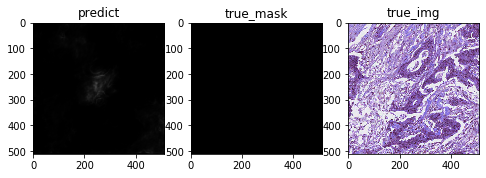

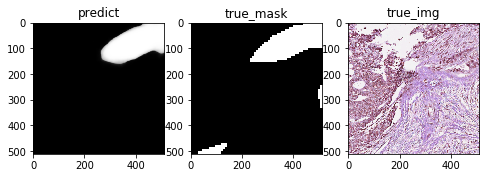

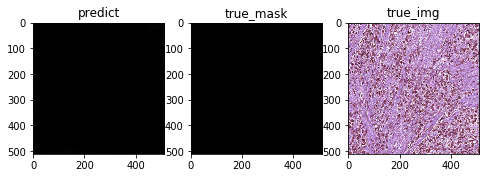

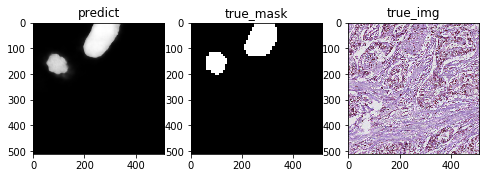

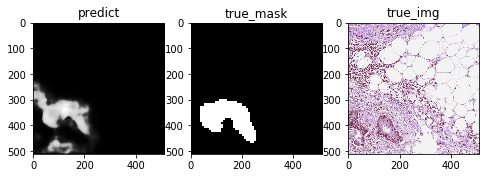

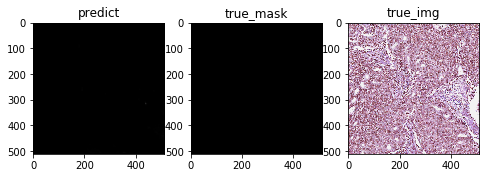

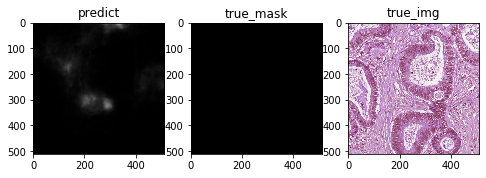

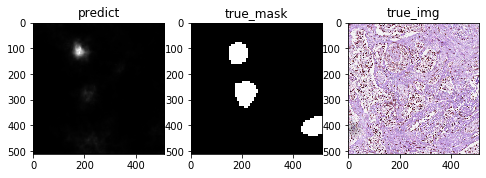

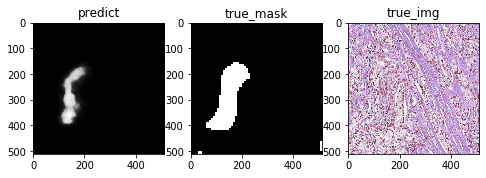

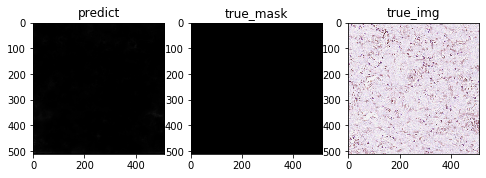

In [19]:
batch_x,batch_y=  test_gen.__getitem__(4)
for i in range(10):

    img,msk = batch_x[i],batch_y[i]
    img = np.expand_dims(img,axis=0)
    pr_msk = model.predict(img)
    pr_msk = np.squeeze(pr_msk)
    plt.figure(figsize = (8,6))
    plt.subplot(1,3,1); plt.title('predict'); plt.imshow(pr_msk)
    plt.subplot(1,3,2); plt.title('true_mask'); plt.imshow(np.squeeze(batch_y[i]))
    plt.subplot(1,3,3); plt.title('true_img'); plt.imshow(np.squeeze((255*img).astype(np.uint8)))

#pr_msk = np.expand_dims(pr_msk,axis=-1)


---